# Install

In [1]:
!pip3 install -q opyplus

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


# Simulation

In [2]:
import os 
import opyplus as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Select version of EnergyPlus

In [3]:
eplus_dir_path = op.get_eplus_base_dir_path((9, 3, 0))

## Define input files

In [4]:
# idf (building model)
base_idf_path = os.path.join(
    eplus_dir_path,
    "ExampleFiles",
    "RefBldgFullServiceRestaurantNew2004_Chicago.idf"
    )

# epw (weather)
epw_path = os.path.join(
    eplus_dir_path,
    "WeatherData",
    "THA_Bangkok.484560_IWEC.epw"
    )

In [5]:
weather_data = op.WeatherData.from_epw(epw_path)
print(weather_data.get_info())

WeatherData
	has datetime instants: False
	latitude: 13.92
	longitude: 100.60
	timezone_offset: 7.0
	elevation: 12.0
	data period: 1983-01-01T00:00:00, 1993-12-31T23:00:00


In [6]:
eplus_dir_path

'/Applications/EnergyPlus-9-3-0'

In [7]:
base_idf_path

'/Applications/EnergyPlus-9-3-0/ExampleFiles/RefBldgFullServiceRestaurantNew2004_Chicago.idf'

In [8]:
epw_path

'/Applications/EnergyPlus-9-3-0/WeatherData/THA_Bangkok.484560_IWEC.epw'

## Define the study plan

### Variables and values

In [9]:
sensitivity_plan = {
    "light" :              [0.5, 1.5], # modify Lights value
    "electric_equipment" : [0.5, 1.5], # modify ElectricEquipment level
    "infiltration" :       [0.5, 1.5], # modify ZoneInfiltration_DesignFlowRate level
    "heating_setpoint" :   [ -1,   1], # modify schedule's upper value
    "cooling_setpoint" :   [ -1,   1], # modify schedule's lower value
    }

### Define the function that will modify the model

In [10]:
def modify_model(epm, parameter, value):

    if parameter == "light":
        # modify light level
        for light in epm.Lights:
            light.watts_per_zone_floor_area *= value
        return

    if parameter == "electric_equipment":
        # modify electric level
        for ee in epm.ElectricEquipment:
            if ee.design_level_calculation_method == "equipmentlevel":
                ee.design_level *= value
            elif ee.design_level_calculation_method == "watts/area":
                ee.watts_per_zone_floor_area *= value
        return

    if parameter == "infiltration":
        # modify infiltration flow
        for inf in epm.ZoneInfiltration_DesignFlowRate:
            if inf.design_flow_rate_calculation_method == "flow/exteriorarea":
                inf.flow_per_exterior_surface_area *= value
            elif inf.design_flow_rate_calculation_method == "airchanges/hour":
                inf.air_changes_per_hour *= value
        return

    if parameter == "heating_setpoint":
        # create a list with all heating setpoint temperature schedules
        # found in ThermostatSetpoint_DualSetpoint objects
        heating_setpoint_temperature_list = []
        # loop on ThermostatSetpoint_DualSetpoint object
        for th_ds in epm.ThermostatSetpoint_DualSetpoint:
            # add heating_setpoint_temperature_schedule_name to list
            heating_setpoint_temperature_list.append(
                th_ds.heating_setpoint_temperature_schedule_name)

        # loop on each heating_setpoint_temperature_schedule and replace value
        for heating_setpoint_sch in sorted(heating_setpoint_temperature_list):
            # get dict of the schedule { 0: schedule'name, 1: schedule type limits name,
            # 2: extensible field 1 value, ... }
            schedule_dict = heating_setpoint_sch.to_dict()
            # get the index of max value
            # (we transform string to float if the value is a string and a can is a digit
            #  not a text)
            first_index = max(
                schedule_dict,
                key=lambda x: float(schedule_dict[x])
                    if isinstance(schedule_dict[x], str) and schedule_dict[x].isdigit()
                    else 0
            )
            # loop on all dict items and modify value if its the max value
            for k, v in schedule_dict.items():
                if v == schedule_dict[first_index]: # it is the max value ?
                    # update value and set it in string format
                    heating_setpoint_sch[k] = str(float(schedule_dict[k]) + value)

        return

    if parameter == "cooling_setpoint":
        # create a list with all cooling setpoint temperature schedules found
        # in ThermostatSetpoint_DualSetpoint objects
        cooling_setpoint_temperature_list = []
        # loop on ThermostatSetpoint_DualSetpoint object
        for th_ds in epm.ThermostatSetpoint_DualSetpoint:
            # add cooling_setpoint_temperature_schedule_name to list
            cooling_setpoint_temperature_list.append(
                th_ds.cooling_setpoint_temperature_schedule_name)

        # loop on each cooling_setpoint_temperature_schedule and replace value
        for cooling_setpoint_sch in set(cooling_setpoint_temperature_list):
            # get dict of the schedule { 0: schedule'name,
            # 1: schedule type limits name, 2: extensible field 1 value, ... }
            schedule_dict = cooling_setpoint_sch.to_dict()
            # get the index of max value
            # (we transform string to float if the value is a string and a can
            #  is a digit not a text)
            first_index = min(
                schedule_dict,
                key=lambda x: float(schedule_dict[x])
                    if isinstance(schedule_dict[x], str) and schedule_dict[x].isdigit()
                    else 100
            )
            # loop on all dict items and modify value if its the min value
            for k, v in schedule_dict.items():
                if v == schedule_dict[first_index]: # it is the min value ?
                    # update value and set it in string format
                    cooling_setpoint_sch[k] = str(float(schedule_dict[k]) + value)

        return

    raise ValueError(f"unknown parameter: {parameter}")

## Create the function that will run the simulation and prepare outputs

In this example we will add specific output variables to the model, simulate and return consumptions.

In [11]:
def simulate_and_get_result(epm, epw_path, simulation_name):
    # add output variables
    epm.output_variable.add({
        0: "*",
        1: "Zone Air Terminal Sensible Heating Energy",
        2: "hourly"
    })
    epm.output_variable.add({
        0: "*",
        1: "Zone Air Terminal Sensible Cooling Energy",
        2: "hourly"
    })

    # simulate
    s = op.simulate(epm, epw_path, simulation_name)

    # get results
    eso = s.get_out_eso()
    eso.create_datetime_index(1993)
    hourly_df = eso.get_data()

    # filter and aggregate outputs
    regex_sensible = "Zone Air Terminal Sensible"
    regex_electric = "electricity:facility"
    regex_gas = "gas:facility"
    sensible = hourly_df.filter(regex=regex_sensible).sum(axis=1).sum()
    electric = hourly_df.filter(regex=regex_electric).sum(axis=1).sum()
    gas = hourly_df.filter(regex=regex_gas).sum(axis=1).sum()

    # return baselines
    return sensible, electric+gas, hourly_df

## Run the study

In [12]:
# calculate baseline
epm = op.Epm.load(base_idf_path)
sensible_need_baseline, total_consumption_baseline, hh1 = simulate_and_get_result(
    epm,
    epw_path,
    "baseline"
)

# run sensitivity study
results = dict()  # {simulation_name: {"total": , "sensible": }
for parameter, values in sensitivity_plan.items():
    for value in values:
        # reload initial model
        print(f"Parameter : {parameter}, and Value : {value}")
        epm = op.Epm.load(base_idf_path)

        # prepare simulation name
        simulation_name = f"{parameter}={str(value)}"

        # modify model
        modify_model(epm, parameter, value)

        # simulate and calculate outputs
        sensible_need, total_consumption, hh2 = simulate_and_get_result(
            epm,
            epw_path,
            simulation_name
        )

        # store results
        results[simulation_name] = dict(
            total=(total_consumption-total_consumption_baseline)/total_consumption_baseline,
            sensible=(sensible_need-sensible_need_baseline)/sensible_need_baseline
        )

called Simulation.from_input on a simulation directory that is not empty (baseline)
called Simulation.from_input on a simulation directory that is not empty (light=0.5)


Parameter : light, and Value : 0.5


called Simulation.from_input on a simulation directory that is not empty (light=1.5)


Parameter : light, and Value : 1.5


called Simulation.from_input on a simulation directory that is not empty (electric_equipment=0.5)


Parameter : electric_equipment, and Value : 0.5


called Simulation.from_input on a simulation directory that is not empty (electric_equipment=1.5)


Parameter : electric_equipment, and Value : 1.5


called Simulation.from_input on a simulation directory that is not empty (infiltration=0.5)


Parameter : infiltration, and Value : 0.5


called Simulation.from_input on a simulation directory that is not empty (infiltration=1.5)


Parameter : infiltration, and Value : 1.5


called Simulation.from_input on a simulation directory that is not empty (heating_setpoint=-1)


Parameter : heating_setpoint, and Value : -1


called Simulation.from_input on a simulation directory that is not empty (heating_setpoint=1)


Parameter : heating_setpoint, and Value : 1


called Simulation.from_input on a simulation directory that is not empty (cooling_setpoint=-1)


Parameter : cooling_setpoint, and Value : -1


called Simulation.from_input on a simulation directory that is not empty (cooling_setpoint=1)


Parameter : cooling_setpoint, and Value : 1


In [13]:
# for _ in epm.lights:
#     print(_)
#     print(_.name)
#     print("="*100)

In [14]:
# for _ in epm.ElectricEquipment:
#     print(_)

In [15]:
sensitivity_plan.items()

dict_items([('light', [0.5, 1.5]), ('electric_equipment', [0.5, 1.5]), ('infiltration', [0.5, 1.5]), ('heating_setpoint', [-1, 1]), ('cooling_setpoint', [-1, 1])])

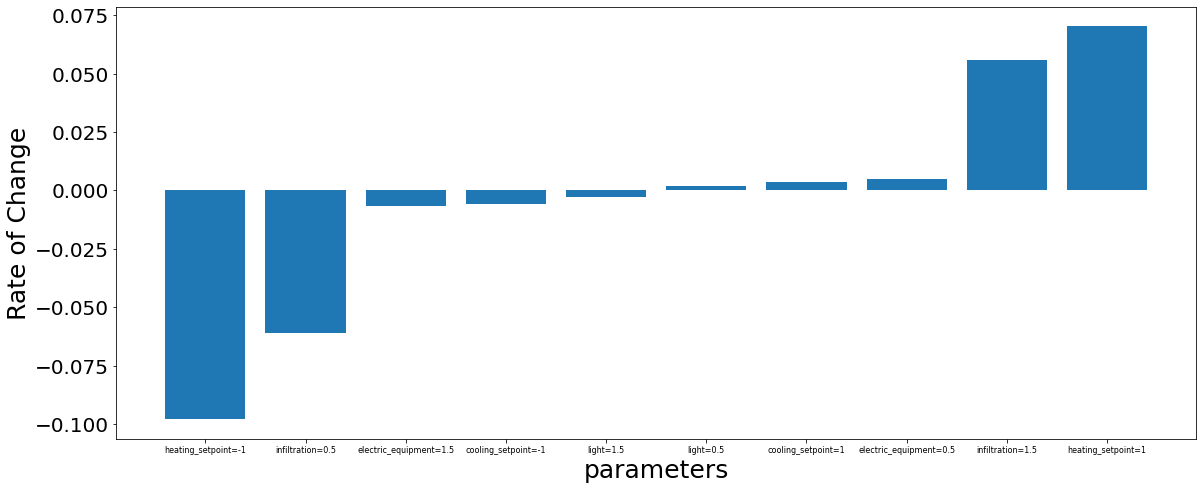

In [16]:
df = pd.DataFrame().from_dict(results).T
df.sort_values(by=["sensible"], inplace=True)

import matplotlib 
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=20) 
_  = plt.figure(figsize=(15,6))
ax = _.add_axes([0,0,1,1])
ax.bar(df.index,df.sensible)
plt.xlabel('parameters', size=25)
plt.ylabel('Rate of Change', size=25)
plt.show()

### Test

In [17]:
s = op.simulate(epm, epw_path, simulation_name)

called Simulation.from_input on a simulation directory that is not empty (cooling_setpoint=1)


In [27]:
eso = s.get_out_eso()
eso.create_datetime_index(2021)
hourly_df = eso.get_data()
hourly_df

,month,day,hour,minute,end_minute,dst,day_type,"environment,Site Outdoor Air Drybulb Temperature","environment,Site Outdoor Air Humidity Ratio","environment,Site Outdoor Air Relative Humidity",...,"cooling:electricity,Meter","electricity:facility,Meter","fans:electricity,Meter","gas:facility,Meter","heating:electricity,Meter","heating:gas,Meter","interiorequipment:electricity,Meter","interiorequipment:gas,Meter","interiorlights:electricity,Meter","water heater:watersystems:gas,Meter"
2021-01-21 00:00:00,1,21,0,0,60,0,WinterDesignDay,-20.6,0.000613,100.0,...,0.0,3.498739e+07,1.266000e+07,6.959130e+08,0.0,6.730640e+08,2516400.0,0.0,0.0,2.284902e+07
2021-01-21 01:00:00,1,21,1,0,60,0,WinterDesignDay,-20.6,0.000613,100.0,...,0.0,2.877663e+07,9.042860e+06,3.574649e+08,0.0,3.573929e+08,0.0,0.0,0.0,7.200000e+04
2021-01-21 02:00:00,1,21,2,0,60,0,WinterDesignDay,-20.6,0.000613,100.0,...,0.0,2.922275e+07,9.495003e+06,3.808995e+08,0.0,3.787682e+08,0.0,0.0,0.0,2.131363e+06
2021-01-21 03:00:00,1,21,3,0,60,0,WinterDesignDay,-20.6,0.000613,100.0,...,0.0,2.605770e+07,6.330002e+06,2.534413e+08,0.0,2.533693e+08,0.0,0.0,0.0,7.200000e+04
2021-01-21 04:00:00,1,21,4,0,60,0,WinterDesignDay,-20.6,0.000613,100.0,...,0.0,2.965524e+07,9.495003e+06,3.804389e+08,0.0,3.803669e+08,0.0,0.0,0.0,7.200000e+04
2021-01-21 05:00:00,1,21,5,0,60,0,WinterDesignDay,-20.6,0.000613,100.0,...,0.0,3.546609e+07,1.266000e+07,6.764413e+08,0.0,6.743099e+08,2516400.0,0.0,0.0,2.131384e+06
2021-01-21 06:00:00,1,21,6,0,60,0,WinterDesignDay,-20.6,0.000613,100.0,...,0.0,3.172892e+07,1.266000e+07,6.848269e+08,0.0,6.682129e+08,2516400.0,0.0,0.0,1.661400e+07
2021-01-21 07:00:00,1,21,7,0,60,0,WinterDesignDay,-20.6,0.000613,100.0,...,0.0,2.010315e+07,1.266000e+07,6.851594e+08,0.0,6.664777e+08,2516400.0,0.0,0.0,1.868172e+07
2021-01-21 08:00:00,1,21,8,0,60,0,WinterDesignDay,-20.6,0.000613,100.0,...,0.0,2.010315e+07,1.266000e+07,6.824193e+08,0.0,6.658067e+08,2516400.0,0.0,0.0,1.661264e+07
2021-01-21 09:00:00,1,21,9,0,60,0,WinterDesignDay,-20.6,0.000613,100.0,...,0.0,2.013975e+07,1.266000e+07,7.177268e+08,0.0,6.612496e+08,2516400.0,0.0,0.0,5.647728e+07


In [24]:
hourly_df['environment,Site Outdoor Air Drybulb Temperature'].unique()

array([-20.6])